In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [7]:
%%writefile studio/websearchAgent01.py

from dotenv import load_dotenv
load_dotenv()

from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver  # Add this import

from langgraph.graph import MessagesState

from studio.webnode import web_search

class State(TypedDict):
    question: str
    search_results: str  # Add this field to store search results
    summarized_result: str


def summarizer(state: State):
    llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

    prompt_template = """
    You are  a helpful assistant. You are will be given a question the context to answer the question. Give a short concise answer to the question based on the context. 
    If you don't know the answer, just say so.

    Question: {question}
    Context: {context}
    Ans: 
    """
    response = llm.invoke(prompt_template.format(question=state["question"], context=state["search_results"]))
    return {"summarized_result": response.content}


graph_builder = StateGraph(State)
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("summarizer", summarizer)

# Simple flow: web search -> chatbot with search results -> summarizer
graph_builder.add_edge(START, "web_search")
graph_builder.add_edge("web_search", "summarizer")
graph_builder.add_edge("summarizer", END)

# Add checkpointer for persistence
checkpointer = MemorySaver()
#graph = graph_builder.compile(checkpointer=checkpointer)  # Add checkpointer her
graph = graph_builder.compile()  # Add checkpointer her

Overwriting studio/websearchAgent01.py


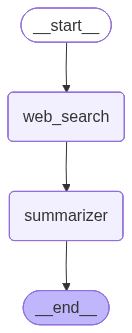

In [3]:
from studio.websearchAgent01 import graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
import uuid

# Generate a unique thread ID
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

In [5]:
config

{'configurable': {'thread_id': '76024059-dc5d-4f44-94d3-6daea6a3216e'}}

In [6]:
graph.invoke({"question":"Find email address of Sneh Lata, Shiv Nadar University"},config=config)

{'query': 'Find email address of Sneh Lata, Shiv Nadar University', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://snu.edu.in/faculty/sneh-lata/', 'title': 'Sneh Lata - Shiv Nadar University', 'content': 'Sneh Lata. Faculty at School of Natural Sciences. Sneh Lata. Associate Professor School of Natural Sciences. Contact Information. Email: [email protected]', 'score': 0.89053273, 'raw_content': None}, {'url': 'https://snu.edu.in/site/assets/files/16490/phd_profile_meet_our_scholarsfinal_1.pdf', 'title': '[PDF] MEET OUR SCHOLARS - Shiv Nadar University', 'content': 'Email: am455@snu.edu.in. Guide: Indranil Biswas. Department of. Mathematics. Email: ak954@snu.edu.in. Guide: Sneh Lata. Department of. Mathematics. Email: di843', 'score': 0.87218446, 'raw_content': None}, {'url': 'https://snu.edu.in/site/assets/files/4259/parents_handbook_a5_040724.pdf', 'title': '[PDF] parents_handbook_a5_040724.pdf - Shiv Nadar University', 'content': 'Sneh lata sn

{'question': 'Find email address of Sneh Lata, Shiv Nadar University',
 'search_results': 'Title: Sneh Lata - Shiv Nadar University\nURL: https://snu.edu.in/faculty/sneh-lata/\nContent: Sneh Lata. Faculty at School of Natural Sciences. Sneh Lata. Associate Professor School of Natural Sciences. Contact Information. Email: [email protected]\n\nTitle: [PDF] MEET OUR SCHOLARS - Shiv Nadar University\nURL: https://snu.edu.in/site/assets/files/16490/phd_profile_meet_our_scholarsfinal_1.pdf\nContent: Email: am455@snu.edu.in. Guide: Indranil Biswas. Department of. Mathematics. Email: ak954@snu.edu.in. Guide: Sneh Lata. Department of. Mathematics. Email: di843\n\nTitle: [PDF] parents_handbook_a5_040724.pdf - Shiv Nadar University\nURL: https://snu.edu.in/site/assets/files/4259/parents_handbook_a5_040724.pdf\nContent: Sneh lata sneh.lata@snu.edu.in. Dr. Niteesh Sahni niteesh.sahni@snu.edu.in. Chemistry, SoNS. Dr. Bimlesh Lochab bimlesh.lochab@snu.edu.in. Dr. Basab Bijayi Dhar.\n',
 'summarized_r